# AOP GEE Time Series Using Python geemap

---
syncID: 048ec0a5e30842acb2fbf1144454830e
title: "Intro to AOP Hyperspectral Data in Google Earth Engine (GEE) using Python geemap"
description: ""
dateCreated: 2023-06-
authors: Bridget Hass
contributors: John Musinsky
estimatedTime: 30 minutes
packagesLibraries: ee, geemap
topics:
languagesTool: Python, Google Earth Engine
dataProduct: DP3.30006.001
code1: https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/tutorials/
tutorialSeries: 
urlTitle: aop-refl-py-geemap
---

<div id="ds-objectives" markdown="1">

### Objectives
After completing this tutorial, you will be able to use Python to:

* Determine the available AOP Surface Directional Reflectance (SDR) datasets in Google Earth Engine
* Use functions to read in SDR data sets and mask out bad weather data (>10% cloud cover)
* Explore the interactive mapping features in geemap
* Create a time-lapse animation of a site

### Requirements

To follow along with this code, you will need to install **Python 3.x** and sign up for a non-commercial Google Earth Engine account here https://code.earthengine.google.com/register. This tutorial was developed using Python 3.9, so if you are installing Python for the first time, we recommend that version. 

We recommend using the **Jupyter Notebooks** IDE so you can run each cell "chunk" individually, although you can also use a different IDE (Interactive Development Environment) of your choice. If not using **Jupyter**, we recommend using **Spyder**, which has similar functionality. 

* **Install Python 3.x and Jupyter Notebooks** 
You can install both Python, Jupyter Notebooks, and Spyder by downloading <a href="https://www.anaconda.com/products/distribution" target="_blank">Anaconda</a>.

* **Sign up for a GEE non-commercial account and set up a cloud project**

* **Install required Python packages**

    * ee
    * geemap
    * matplotlib

The last optional part, to create a time-lapse uses the `cartoee` package in geemap, which requires the following packages:

    * cartopy
    * geos
    * shapely
    * pyproj
    
Note: if cartopy is not installing using conda or pip install, you may need to find the wheel file specific to your Python version, eg. `pip install Cartopy-0.20.2-cp39-cp39-win_amd64.whl`.

In [1]:
import os
import ee
import geemap

In [2]:
ee.Authenticate()

Enter verification code: 4/1AZEOvhWujEw0KJHQqPGBWhn_cELP0Vb2wKTovKfpaCm1VASHSJM2-6Mb7zE

Successfully saved authorization token.


In [3]:
ee.Initialize()

The code below creates and displays the GEE interactive `Map` panel. It will then be updated by the subsequent code chunks.

In [4]:
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

First we need to set the NEON <a href="https://www.neonscience.org/field-sites/explore-field-sites" target="_blank">NEON field site</a> (4-letter code) and the years of data we want to pull in. 

In this example we will look at the <a href="https://www.neonscience.org/field-sites/grsm" target="_blank">Great Smokey Mountain (GRSM)</a> site. To see all the AOP SDR data that are available in GEE, and the years of data available at GRSM, run the code chunks below.

In [5]:
# Read in the NEON AOP Surface Directional Reflectance (SDR) Collection:
sdrCol = ee.ImageCollection('projects/neon-prod-earthengine/assets/DP3-30006-001')

# List all available sites in the NEON SDR image collection:
print('All Available NEON SDR Images:')
print(sdrCol.aggregate_array('system:index').getInfo())

# Get the flight year and site information
flightYears = sdrCol.aggregate_array('FLIGHT_YEAR').getInfo()
sites = sdrCol.aggregate_array('NEON_SITE').getInfo()

All Available NEON SDR Images:
['2013_CPER_1_SDR', '2016_CLBJ_1_SDR', '2016_GRSM_2_SDR', '2016_HARV_3_SDR', '2017_CLBJ_2_SDR', '2017_CPER_3_SDR', '2017_GRSM_3_SDR', '2017_SERC_3_SDR', '2018_CLBJ_3_SDR', '2019_CLBJ_4_SDR', '2019_HARV_6_SDR', '2019_HEAL_3_SDR', '2019_JORN_3_SDR', '2019_SOAP_4_SDR', '2020_CPER_5_SDR', '2020_CPER_7_SDR', '2020_NIWO_4_SDR', '2021_ABBY_4_SDR', '2021_CLBJ_5_SDR', '2021_CPER_8_SDR', '2021_GRSM_5_SDR', '2021_HEAL_4_SDR', '2021_JORN_4_SDR', '2021_SJER_5_SDR', '2021_SOAP_5_SDR']


In [6]:
site = 'GRSM'

In [7]:
# See the years of data available for the specified site:
print('\nYears of data available in GEE for site',site,':')
print([year_site[0] for year_site in zip(flightYears,sites) if site in year_site])


Years of data available in GEE for site GRSM :
[2016, 2017, 2021]


If you'd like to read in every year, you can use `ee.List.sequence(start_year, end_year)`, but since AOP data is not collected  every year at every site, and all of the data has not yet been added to GEE, we recommend you first check the data availability and then use `ee.List` to specify only data that are available (or the dates of interest). For this example, we'll create an earth engine list (`ee.List`) of the GRSM data from 2016, 2017, and 2021:

In [8]:
years = ee.List([2016, 2017, 2021])
print(years.getInfo())

[2016, 2017, 2021]


Next we can write a function that will read in the AOP SDR image collection, filter on a specified site, and then read in the `Weather_Quality_Indicator` band and mask the data to include only the clear weather (<10% cloud cover) data.

In [9]:
# function to read the AOP SDR image collection
# selects the data bands and masks to include only the clear-weather data (<10% cloud cover)
def sdr_clear_weather(year):

    # Specify the start and end dates
    start_date = ee.Date.fromYMD(year, 1, 1) 
    end_date = start_date.advance(1, "year")
    
    # Filter the SDR image collection on the site and dates
    aop_sdr = ee.ImageCollection('projects/neon-prod-earthengine/assets/DP3-30006-001') \
        .filterDate(start_date, end_date) \
        .filterMetadata('NEON_SITE', 'equals', site).mosaic()
    
    # Read in only the data bands, all of which start with "B", eg. "B001"
    sdr_data = aop_sdr.select('B.*')
    
    # Extract Weather Quality Indicator layer
    weather_quality_band = aop_sdr.select(['Weather_Quality_Indicator']);

    # Select only the clear weather data (<10% cloud cover)
    clear_weather = weather_quality_band.eq(1); # 1 = 0-10% cloud cover
    
    # Mask out all cloudy pixels from the SDR data cube
    sdr_clear_weather = sdr_data.updateMask(clear_weather);

    return sdr_clear_weather

We can now map this function over the list of years, and then add these images to the Map layer in a loop.

In [10]:
# Map the function over the years of data, defined before as an ee.List
images = years.map(sdr_clear_weather)

# Set the visualization parameters so contrast is maximized, and display RGB bands (true-color image)
visParams = {'min':0,'max':1200,'gamma':0.9,'bands':['B053','B035','B019']};

for index in range(0, len(years.getInfo())):
    image = ee.Image(images.get(index))
    layer_name = site + " " + str(years.getInfo()[index]) + " SDR" 
    print('Adding ' + layer_name)
    Map.addLayer(image, visParams, layer_name)
    
# Center the map on the site
grsmCenter = ee.Geometry.Point([-83.5, 35.7]);
Map.centerObject(grsmCenter, 11);

Adding GRSM 2016 SDR
Adding GRSM 2017 SDR
Adding GRSM 2021 SDR


The function below extracts the weather quality band for each year of data in the image collection.

In [11]:
def yearly_weather_band(year):

    start_date = ee.Date.fromYMD(year, 1, 1) 
    end_date = start_date.advance(1, "year")
    
#     print('filtering image collection by date and site')
    aop_sdr = ee.ImageCollection('projects/neon-prod-earthengine/assets/DP3-30006-001') \
        .filterDate(start_date, end_date) \
        .filterMetadata('NEON_SITE', 'equals', site).mosaic()
    
    # Extract Weather Quality Indicator band
    weather_quality_band = aop_sdr.select(['Weather_Quality_Indicator']);

    return weather_quality_band

In [12]:
weather_bands = years.map(yearly_weather_band)

# Define a palette for the weather - to match NEON AOP's weather color conventions (green-yellow-red)
gyrPalette = ['00ff00', # green (<10% cloud cover)
              'ffff00', # yellow (10-50% cloud cover)
              'ff0000' # red (>50% cloud cover)
             ];

# parameters to display the weather bands (cloud conditions) with the green-yellow-red palette
weather_visParams = {'min': 1, 'max': 3, 'palette': gyrPalette, 'opacity': 0.3};

# loop through the layers and add them to the Map
for index in range(0, len(years.getInfo())):
    weather_band = ee.Image(weather_bands.get(index))
    layer_name = site + " " + str(years.getInfo()[index]) + " Cloud Cover" 
    print('Adding ' + layer_name)
    Map.addLayer(weather_band, weather_visParams, layer_name, 0) # 0 means the layers will not be selected "on" by default

Adding GRSM 2016 Cloud Cover
Adding GRSM 2017 Cloud Cover
Adding GRSM 2021 Cloud Cover


Now let's add the full image collection (all years) for a different site as a Map Layer. For this example, we'll use the site <a href="https://www.neonscience.org/field-sites/clbj" target="_blank">Lyndon B. Johnson National Grassland (CLBJ)</a>, as there are 5 years of reflectance data ingested in GEE for that site. This is a nice example for displaying the time-lapse feature in the interactive map.

In [13]:
site = 'CLBJ'

In [14]:
# See the years of data available for the specified site:
print('\nData available in GEE for site',site,':')
print([year_site[0] for year_site in zip(flightYears,sites) if site in year_site])


Data available in GEE for site CLBJ :
[2016, 2017, 2018, 2019, 2021]


In [15]:
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [16]:
# Filter the SDR image collection at that site from all available years
siteSDR = sdrCol.filterMetadata('NEON_SITE', 'equals', site);

# Read in only the data bands, all of which start with "B", eg. "B001"
siteSDR_data = siteSDR.select('B.*')

# Read in the weather quality indicator band
siteSDR_weatherQA = siteSDR.select(['Weather_Quality_Indicator']);

# Set the visualization parameters so contrast is maximized, and display RGB bands (true-color image)
visParams = {'min':0,'max':1200,'gamma':0.9,'bands':['B053','B035','B019']};

# Add the site image collection as a layer to the Map
Map.addLayer(siteSDR_data, visParams, site + ' SDR');

# Add the weather quality layer as well, for context
Map.addLayer(siteSDR_weatherQA, weather_visParams, site + ' Weather Quality Indicator',0)

# Center the map on the site - change the lat/lon below if you are using a different site
lon = -97.63
lat = 33.37
siteCenter = ee.Geometry.Point([lon, lat]);
Map.centerObject(siteCenter, 12);

Lastly, optionally, we can create a time-lapse gif of the site over all the collections. This part follows along code from the GeoPython 2021 workshop: https://geemap.org/workshops/GeoPython_2021/#create-timelapse-animations.

In [17]:
from geemap import cartoee
import matplotlib.pyplot as plt

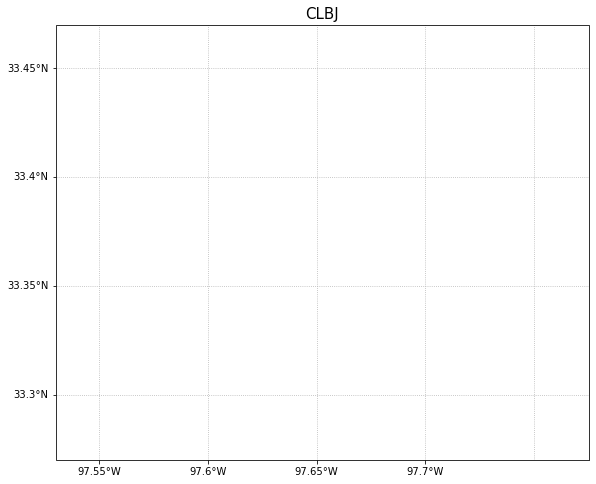

In [18]:
w = 0.1
h = 0.1

region = [lon - w, lat - h, lon + w, lat + h]

fig = plt.figure(figsize=(10, 8))

# use cartoee to get a map
ax = geemap.cartoee.get_map(image, region=region, vis_params=visParams)

# add gridlines to the map at a specified interval
geemap.cartoee.add_gridlines(ax, interval=[0.05, 0.05], linestyle=":")

# add scale bar
scale_bar_dict = {
    "length": 10,
    "xy": (0.1, 0.05),
    "linewidth": 3,
    "fontsize": 20,
    "color": "white",
    "unit": "km",
    "ha": "center",
    "va": "bottom",
}
cartoee.add_scale_bar_lite(ax, **scale_bar_dict)

ax.set_title(label='CLBJ', fontsize=15)

plt.show()

In [19]:
cartoee.get_image_collection_gif(
    ee_ic=siteSDR,
    out_dir=os.path.expanduser("~/Downloads/timelapse"),
    out_gif="clbj_gee_timelapse.gif",
    vis_params=visParams,
    region=region,
    fps=1,
    mp4=True,
    grid_interval=(0.05, 0.05),
    plot_title="CLBJ AOP SDR Time Lapse",
    date_format='YYYY-MM-dd',
    fig_size=(10, 8),
    dpi_plot=100,
    file_format="png",
    scale_bar_dict=scale_bar_dict,
)

GIF saved to C:\Users\bhass\Downloads\timelapse\clbj_gee_timelapse.gif
MP4 saved to C:\Users\bhass\Downloads\timelapse\clbj_gee_timelapse.mp4
